<img src="../source/_static/Gamma_Facet_Logo_RGB_LB.svg" width="500" style="padding-bottom: 70px; padding-top: 70px; margin: auto; display: block">

FACET is composed of the following key components:

- **Model Inspection**

    FACET introduces a new algorithm to quantify dependencies and interactions between features in ML models. This new tool for human-explainable AI adds a new, global perspective to the observation-level explanations provided by the popular [SHAP](https://shap.readthedocs.io/en/latest/) approach. To learn more about FACET's model inspection capabilities, see the getting started example below.


- **Model Simulation**

    FACET's model simulation algorithms use ML models for *virtual experiments* to help identify scenarios that optimise predicted  outcomes. To quantify the uncertainty in simulations, FACET utilises a range of bootstrapping algorithms including stationary and stratified bootstraps. For an example of FACET’s bootstrap simulations, see the getting started example below.    
    
    
- **Enhanced Machine Learning Workflow**  

    FACET offers an efficient and transparent machine learning workflow, enhancing [scikit-learn]( https://scikit-learn.org/stable/index.html)'s tried and tested pipelining paradigm with new capabilities for model selection, inspection, and simulation. FACET also introduces [sklearndf](https://github.com/BCG-Gamma/sklearndf), an augmented version of *scikit-learn* with enhanced support for *pandas* dataframes that ensures end-to-end traceability of features.       

In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

import warnings

warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt

def _configure_matplotlib():
    # set global options for matplotlib

    import matplotlib

    matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
    matplotlib.rcParams["figure.dpi"] = 72


_configure_matplotlib()

del _configure_matplotlib

# Pipelining & Model Ranking

To demonstrate the model inspection capability of FACET, we first create a pipeline to fit a learner. In this simple example we use the [diabetes dataset](https://web.stanford.edu/~hastie/Papers/LARS/diabetes.data) which contains age, sex, BMI and blood pressure along with 6 blood serum measurements as features. This dataset was used in this
[publication](https://statweb.stanford.edu/~tibs/ftp/lars.pdf). A transformed version of this dataset is also available on scikit-learn [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset).

In this quickstart we will train a Random Forest regressor using 10 repeated 5-fold CV to predict disease progression after one year. With the use of *sklearndf* we can create a *pandas* DataFrame compatible workflow. However, FACET provides additional enhancements to keep track of our feature matrix and target vector using a sample object (`Sample`) and easily compare hyperparameter configurations and even multiple learners with the `LearnerRanker`.

In [2]:
# standard imports
import pandas as pd
from sklearn.model_selection import RepeatedKFold

# some helpful imports from sklearndf
from sklearndf.pipeline import RegressorPipelineDF
from sklearndf.regression import RandomForestRegressorDF

# relevant FACET imports
from facet.data import Sample
from facet.selection import LearnerRanker, LearnerGrid

# declaring url with data
data_url = 'https://web.stanford.edu/~hastie/Papers/LARS/diabetes.data'

#importing data from url
diabetes_df = pd.read_csv(data_url, delimiter='\t').rename(
    # renaming columns for better readability
    columns={
        'S1': 'TC', # total serum cholesterol
        'S2': 'LDL', # low-density lipoproteins
        'S3': 'HDL', # high-density lipoproteins
        'S4': 'TCH', # total cholesterol/ HDL
        'S5': 'LTG', # lamotrigine level
        'S6': 'GLU', # blood sugar level
        'Y': 'Disease_progression' # measure of progress since 1yr of baseline
    }
)

# create FACET sample object
diabetes_sample = Sample(observations=diabetes_df, target_name="Disease_progression")

# create a (trivial) pipeline for a random forest regressor
rnd_forest_reg = RegressorPipelineDF(
    regressor=RandomForestRegressorDF(n_estimators=200, random_state=42)
)

# define grid of models which are "competing" against each other
rnd_forest_grid = [
    LearnerGrid(
        pipeline=rnd_forest_reg,
        learner_parameters={
            "min_samples_leaf": [8, 11, 15],
            "max_depth": [4, 5, 6],
        }
    ),
]

# create repeated k-fold CV iterator
rkf_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# rank your candidate models by performance (default is mean CV score - 2*SD)
ranker = LearnerRanker(
    grids=rnd_forest_grid, cv=rkf_cv, n_jobs=-3
).fit(sample=diabetes_sample)

# get summary report
ranker.summary_report()

ranking_score  r2_score                          regressor  \
                        mean       std                     type   
rank                                                              
0         0.315374  0.443288  0.063957  RandomForestRegressorDF   
1         0.315305  0.443665  0.064180  RandomForestRegressorDF   
2         0.313433  0.441763  0.064165  RandomForestRegressorDF   
3         0.313297  0.442263  0.064483  RandomForestRegressorDF   
4         0.313186  0.442063  0.064439  RandomForestRegressorDF   
5         0.313048  0.442184  0.064568  RandomForestRegressorDF   
6         0.312822  0.441813  0.064495  RandomForestRegressorDF   
7         0.312539  0.440957  0.064209  RandomForestRegressorDF   
8         0.311975  0.441238  0.064631  RandomForestRegressorDF   

                                 
     min_samples_leaf max_depth  
rank                             
0                  11         5  
1                  11         6  
2                  11         4  
3                   8         6  
4                  15         5  
5                  15         6  
6                   8         5  
7                  15         4  
8                   8         4

We can see based on this minimal workflow that a value of 11 for minimum
samples in the leaf and 5 for maximum tree depth was the best performing
of the three considered values.
This approach easily extends to additional hyperparameters for the learner,
and for multiple learners.

# Model inspection

FACET implements several model inspection methods for
[scikit-learn](<https://scikit-learn.org/stable/index.html>) estimators.
FACET enhances model inspection by providing global metrics that complement 
the local perspective of SHAP. The key global metrics for each pair of 
features in a model are:

- **Synergy**

  The degree to which the model combines information from one feature with 
  another to predict the target. For example, let's assume we are predicting 
  cardiovascular health using age and gender and the fitted model includes 
  a complex interaction between them. This means these two features are 
  synergistic for predicting cardiovascular health. Further, both features 
  are important to the model and removing either one would significantly 
  impact performance. Let's assume age brings more information to the joint
  contribution than gender. This asymmetric contribution means the synergy for
  (age, gender) is less than the synergy for (gender, age). To think about it
  another way, imagine the prediction is a coordinate you are trying to reach.
  From your starting point, age gets you much closer to this point than 
  gender, however, you need both to get there. Synergy reflects the fact 
  that gender gets more help from age (higher synergy from the perspective 
  of gender) than age does from gender (lower synergy from the perspective of
  age) to reach the prediction. *This leads to an important point: synergy 
  is a naturally asymmetric property of the global information two interacting 
  features contribute to the model predictions.* Synergy is expressed as a 
  percentage ranging from 0% (full autonomy) to 100% (full synergy).


- **Redundancy**

  The degree to which a feature in a model duplicates the information of a 
  second feature to predict the target. For example, let's assume we had 
  house size and number of bedrooms for predicting house price. These 
  features capture similar information as the more bedrooms the larger 
  the house and likely a higher price on average. The redundancy for 
  (number of bedrooms, house size) will be greater than the redundancy 
  for (house size, number of bedrooms). This is because house size 
  "knows" more of what number of bedrooms does for predicting house price 
  than vice-versa. Hence, there is greater redundancy from the perspective 
  of number of bedrooms. Another way to think about it is removing house 
  size will be more detrimental to model performance than removing number 
  of bedrooms, as house size can better compensate for the absence of 
  number of bedrooms. This also implies that house size would be a more 
  important feature than number of bedrooms in the model. *The important 
  point here is that like synergy, redundancy is a naturally asymmetric 
  property of the global information feature pairs have for predicting 
  an outcome.* Redundancy is expressed as a percentage ranging from 0% 
  (full uniqueness) to 100% (full redundancy).

In [3]:
# fit the model inspector
from facet.inspection import LearnerInspector
inspector = LearnerInspector(n_jobs=-3)
inspector.fit(crossfit=ranker.best_model_crossfit_)

**Synergy**

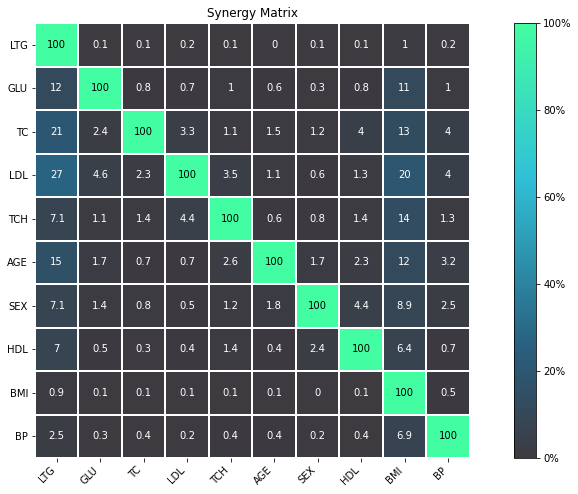

In [4]:
# visualise synergy as a matrix
from pytools.viz.matrix import MatrixDrawer
synergy_matrix = inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy Matrix")

# save copy of plot to _static directory for documentation
plt.savefig(
    "../source/_static/synergy_matrix.png", bbox_inches="tight", pad_inches=0
)

For any feature pair (A, B), the first feature (A) is the row, and the second
feature (B) the column. For example, looking across the row for `LTG` (Lamotrigine)
there is hardly any synergy with other features in the model (≤ 1%).
However, looking down the column for `LTG` (i.e., from the perspective of other features
relative with `LTG`) we find that many features (the rows) are aided by synergy with
with `LTG` (up to 27% in the case of LDL). We conclude that:

- `LTG` is a strongly autonomous feature, displaying minimal synergy with other
  features for predicting disease progression after one year.
- The contribution of other features to predicting disease progression after one
  year is partly enabled by the presence of `LTG`.

High synergy between pairs of features must be considered carefully when investigating
impact, as the values of both features jointly determine the outcome. It would not make
much sense to consider `LDL` without the context provided by `LTG` given close
to 27% synergy of `LDL` with `LTG` for predicting progression after one year.

**Redundancy**

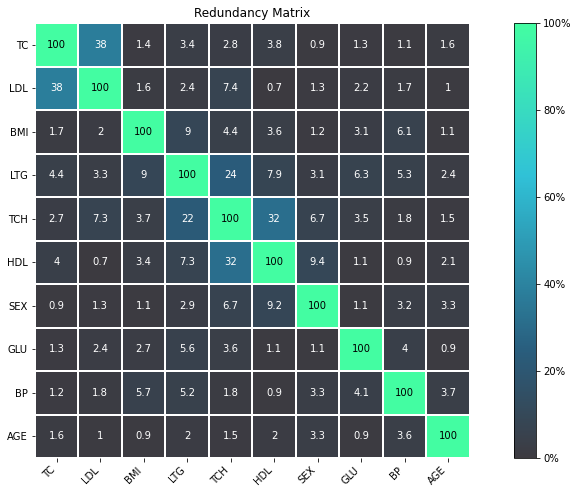

In [5]:
# visualise redundancy as a matrix
redundancy_matrix = inspector.feature_redundancy_matrix()
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy Matrix")

# save copy of plot to _static directory for documentation
plt.savefig(
    "../source/_static/redundancy_matrix.png",
    bbox_inches="tight",
    pad_inches=0,
)

For any feature pair (A, B), the first feature (A) is the row, and the second feature
(B) the column. For example, if we look at the feature pair (`LDL`, `TC`) from the
perspective of `LDL` (Low-Density Lipoproteins), then we look-up the row for `LDL`
and the column for `TC` and find 38% redundancy. This means that 38% of the information
in `LDL` to predict disease progression is duplicated in `TC`. This
redundancy is the same when looking "from the perspective" of `TC` for (`TC`, `LDL`),
but need not be symmetrical in all cases (see `LTG` vs. `TCH`).

If we look at `TCH`, it has between 22–32% redundancy each with `LTG` and `HDL`, but
the same does not hold between `LTG` and `HDL` – meaning `TCH` shares different
information with each of the two features.

**Clustering redundancy**

As detailed above redundancy and synergy for a feature pair is from the
"perspective" of one of the features in the pair, and so yields two distinct
values. However, a symmetric version can also be computed that provides not
only a simplified perspective but allows the use of (1 - metric) as a
feature distance. With this distance hierarchical, single linkage clustering
is applied to create a dendrogram visualization. This helps to identify
groups of low distance, features which activate "in tandem" to predict the
outcome. Such information can then be used to either reduce clusters of
highly redundant features to a subset or highlight clusters of highly
synergistic features that should always be considered together.

Let's look at the example for redundancy.

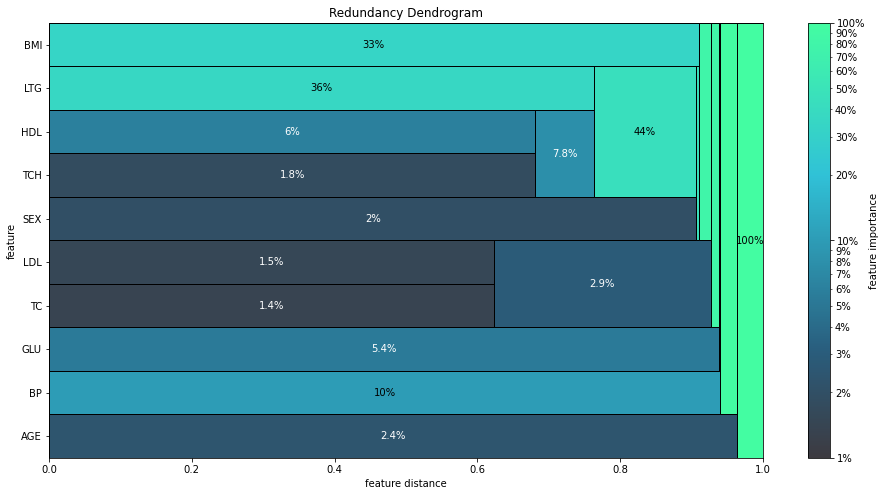

In [6]:
# visualise redundancy using a dendrogram
from pytools.viz.dendrogram import DendrogramDrawer
redundancy = inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(data=redundancy, title="Redundancy Dendrogram")

# save copy of plot to _static directories for documentation
plt.savefig(
    "../source/_static/redundancy_dendrogram.png",
    bbox_inches="tight",
    pad_inches=0,
)

Based on the dendrogram we can see that the feature pairs (`LDL`, `TC`)
and (`HDL`, `TCH`) each represent a cluster in the dendrogram and that `LTG` and `BMI`
have the highest importance. As potential next actions we could explore the impact of
removing `TCH`, and one of `TC` or `LDL` to further simplify the model and obtain a
reduced set of independent features.

# Simulation

Taking the `BMI` feature as an example of an important and highly independent feature,
we do the following for the simulation:

- We use FACET's `ContinuousRangePartitioner` to split the range of observed values of
  `BMI` into intervals of equal size. Each partition is represented by the central value
  of that partition.
- For each partition, the simulator creates an artificial copy of the original sample
  assuming the variable to be simulated has the same value across all observations –
  which is the value representing the partition. Using the best `LearnerCrossfit`
  acquired from the ranker, the simulator now re-predicts all targets using the models
  trained for all folds and determines the average uplift of the target variable
  resulting from this.
- The FACET `SimulationDrawer` allows us to visualise the result; both in a
  *matplotlib* and a plain-text style.

Finally, because FACET can use bootstrap cross validation, we can create a crossfit
from our previous `LearnerRanker` best model to perform the simulation, so we can
quantify the uncertainty by using bootstrap confidence intervals.

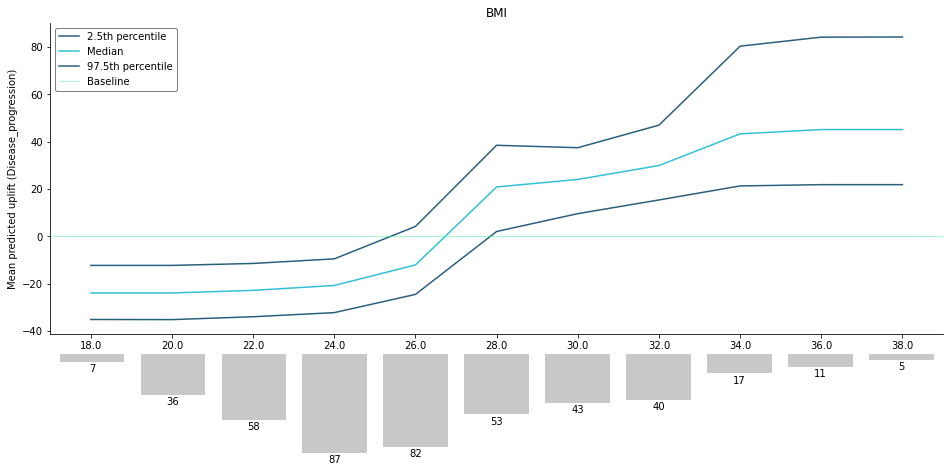

In [7]:
# FACET imports
from facet.validation import BootstrapCV
from facet.crossfit import LearnerCrossfit
from facet.simulation import UnivariateUpliftSimulator
from facet.data.partition import ContinuousRangePartitioner
from facet.simulation.viz import SimulationDrawer

# create bootstrap CV iterator
bscv = BootstrapCV(n_splits=1000, random_state=42)

# create a bootstrap CV crossfit for simulation using best model
boot_crossfit = LearnerCrossfit(
    pipeline=ranker.best_model_,
    cv=bscv,
    n_jobs=-3,
    verbose=False,
).fit(sample=diabetes_sample)

SIM_FEAT = "BMI"
simulator = UnivariateUpliftSimulator(crossfit=boot_crossfit, n_jobs=-3)

# split the simulation range into equal sized partitions
partitioner = ContinuousRangePartitioner()

# run the simulation
simulation = simulator.simulate_feature(feature_name=SIM_FEAT, partitioner=partitioner)

# visualise results
SimulationDrawer().draw(data=simulation, title=SIM_FEAT)

# save copy of plot to _static directory for documentation
plt.savefig(
    "../source/_static/simulation_output.png",
    bbox_inches="tight",
    pad_inches=0,
)

We would conclude from the figure that higher values of `BMI` are associated with
an increase in disease progression after one year, and that for a `BMI` of 28
and above, there is a significant increase in disease progression after one year
of at least 26 points.